# Optimal location for studying in London
## Capstone Project
### IBM Data Science Professional Certificate
https://www.coursera.org/learn/applied-data-science-capstone

#### Business problem description

Which is the most recommended location for living in London assuming you want to study at Middlesex University? The accommodation needs to be close to the university, but not too far from the city centre. Supermarkets and cafes in the neighborhood will also be taken into consideration. However, being a student the rent is a key factor to bear in mind. A one bedroom house or flat is preferred. 

London is a large city with plenty of opportunities. There are many interesting spots in this city, touristic attractions, monuments and even business areas. All these factors are important for looking for accommodation. Rental prices in London are high, the area must be chosen in a way that minimises it while still enjoying the proximity to the key locations mentioned before.

The target audience is university students who are looking for accommodation in London, and don't want to give up on all the beauties of London. 

#### Data

The different boroughs of London will be checked, searching for venues of interest and average rental prices.

Data sources:
- Foursquare
- https://data.london.gov.uk/dataset/average-private-rents-borough
- https://data.london.gov.uk/dataset/postcode-directory-for-london
- https://www.freemaptools.com/download/outcode-postcodes/postcode-outcodes.csv
- https://www.doogal.co.uk/PostcodeDistrictsCSV.ashx

The accomodation must be located close to Middlesex University. Foursquare data will be used to search for venues around this location. The postcode directory of the city will be used to group the venues information and average rent per area by borough.

#### Data import and preprocessing

In [1]:
import pandas as pd
import numpy as np
import requests # library to handle requests
from pandas.io.json import json_normalize

%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot') # for ggplot-like style

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans 
from sklearn.pipeline import make_pipeline

In [2]:
#!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

address = "Middlesex University London"
geolocator = Nominatim(user_agent="London_Accommodation")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates of {} are {}, {}.'.format(address, latitude, longitude))

The geographical coordinates of Middlesex University London are 51.590297050000004, -0.2296322094540291.


In [3]:
# Import the UK postcodes from CSV file
url = 'https://www.doogal.co.uk/PostcodeDistrictsCSV.ashx'
dfs = pd.read_csv(url)
dfs.head(3)

,Postcode,Latitude,Longitude,Easting,Northing,Grid Reference,Town/Area,Region,Postcodes,Active postcodes,Population,Households,Nearby districts
0,AB1,57.1269,-2.13644,391839.0,804005.0,NJ918040,Aberdeen,Aberdeen,2655.0,0.0,NaN,NaN,"AB10, AB9, AB15, AB25, AB2, AB12, AB16, AB11, ..."
1,AB2,57.1713,-2.14152,391541.0,808948.0,NJ915089,Aberdeen,Aberdeen,3070.0,0.0,NaN,NaN,"AB16, AB22, AB24, AB25, AB1, AB9, AB15, AB10, ..."
2,AB3,57.0876,-2.59624,363963.0,799780.0,NO639997,Aberdeen,Aberdeen,2168.0,0.0,NaN,NaN,"AB31, AB34, AB52, AB33, AB14, AB32, AB30, AB13..."


Select only those postcodes in the area of interest in order to reduce the amount of data. These postcodes are those starting wih NW, E, N and W.

In [4]:
dfpc = dfs[dfs['Postcode'].str.match('^NW\d|^E\d|^N\d|^W\d')]
dfpc = dfpc[~dfpc['Town/Area'].str.contains('Non-geographic')]

Drop the non-useful columns.

In [5]:
dfpc.drop(['Easting', 'Northing', 'Grid Reference', 'Active postcodes', 'Postcodes', 'Population', 'Households', 'Nearby districts'], axis=1, inplace=True)

In [6]:
# Show resulting dataframe
dfpc

,Postcode,Latitude,Longitude,Town/Area,Region
805,E1,51.5163,-0.060428,"Aldgate, Bishopsgate, Whitechapel, Shoreditch,...",Tower Hamlets
806,E1W,51.5118,-0.059323,Wapping,Tower Hamlets
807,E2,51.5301,-0.062251,"Bethnal Green, Haggerston, Shoreditch, Cambrid...",Tower Hamlets
808,E3,51.5282,-0.025800,"Bow, Bromley-by-Bow, Old Ford, Mile End, Three...",Tower Hamlets
809,E4,51.6238,-0.003245,"Chingford, Sewardstone, Highams Park",Waltham Forest
...,...,...,...,...,...
2946,W10,51.5202,-0.221196,"North Kensington, Queens Park",Kensington and Chelsea
2947,W11,51.5128,-0.216585,"Notting Hill, Holland Park",Kensington and Chelsea
2948,W12,51.5094,-0.238236,"Shepherds Bush, White City",Hammersmith and Fulham
2949,W13,51.5131,-0.321423,"West Ealing, Northfields",Ealing


The next step is importing the data about rental prices by area and match it with the dataframe containing the postcodes of interest.

In [7]:
# Import the UK rental prices from CSV file
url = 'https://data.london.gov.uk/download/average-private-rents-borough/73b9fb07-b5bb-4a53-88b7-c17269879a08/voa-average-rent-borough.xls'
dfr = pd.read_excel(url, index_col=None, header=2, sheet_name='Raw data')
dfr.head(3)

,Year,Quarter,Code,Area,Category,Count of rents,Average,Lower quartile,Median,Upper quartile
0,2011,Q2,E09000001,City of London,Room,-,-,-,-,-
1,2011,Q2,E09000002,Barking and Dagenham,Room,92,336,282,347,390
2,2011,Q2,E09000003,Barnet,Room,945,450,399,433,500


Keep only the rents for the last year.

In [8]:
dfr = dfr[dfr['Year'] == dfr['Year'].max()]
dfr.head()

,Year,Quarter,Code,Area,Category,Count of rents,Average,Lower quartile,Median,Upper quartile
5852,2019,Q1,E09000001,City of London,Room,0,.,.,.,.
5853,2019,Q1,E09000002,Barking and Dagenham,Room,10,650,600,650,700
5854,2019,Q1,E09000003,Barnet,Room,50,602,550,588,650
5855,2019,Q1,E09000004,Bexley,Room,40,577,550,585,672
5856,2019,Q1,E09000005,Brent,Room,90,638,500,602,700


Filter by one bedroom houses.

In [9]:
dfr = dfr[dfr['Category'] == 'One Bedroom']

Clean table

In [10]:
dfr.drop(['Year', 'Code', 'Category', 'Count of rents', 'Lower quartile', 'Median', 'Upper quartile'], axis=1, inplace=True)

Check data types.

In [11]:
dfr.dtypes

Quarter    object
Area       object
Average    object
dtype: object

Convert Average column to numbers.

In [12]:
dfr = dfr.astype({'Average': 'int64'})
dfr.dtypes

Quarter    object
Area       object
Average     int64
dtype: object

Group by area in order to average the rents on the four quarters.

In [13]:
dfr = dfr.groupby('Area').mean().reset_index()

Rename average rent column as Rent

In [14]:
dfr = dfr.rename(columns={'Average': 'Rent'}, errors="raise")
dfr['Area'] = dfr['Area'].str.title()

In [15]:
dfr

,Area,Rent
0,Barking And Dagenham,965
1,Barnet,1147
2,Bexley,821
3,Brent,1241
4,Bromley,972
5,Camden,1659
6,City Of London,2083
7,Croydon,931
8,East,666
9,East Midlands,481


Go back to dataframe containing postcodes and coordinates.

In [16]:
dfpc['Region'] = dfpc['Region'].str.title()
dfpc['Region'].unique()

array(['Tower Hamlets', 'Waltham Forest', 'Hackney', 'Newham',
       'Redbridge', 'Camden', 'Barnet', 'Haringey', 'Islington',
       'Enfield', 'Brent', 'Westminster', 'London', 'Ealing', 'Hounslow',
       'Hammersmith And Fulham', 'Kensington And Chelsea'], dtype=object)

Left join of postal codes dataframe with rents dataframe

In [17]:
df_rents = dfpc.merge(dfr, how='left', left_on='Region', right_on='Area')
df_rents

,Postcode,Latitude,Longitude,Town/Area,Region,Area,Rent
0,E1,51.5163,-0.060428,"Aldgate, Bishopsgate, Whitechapel, Shoreditch,...",Tower Hamlets,Tower Hamlets,1494
1,E1W,51.5118,-0.059323,Wapping,Tower Hamlets,Tower Hamlets,1494
2,E2,51.5301,-0.062251,"Bethnal Green, Haggerston, Shoreditch, Cambrid...",Tower Hamlets,Tower Hamlets,1494
3,E3,51.5282,-0.025800,"Bow, Bromley-by-Bow, Old Ford, Mile End, Three...",Tower Hamlets,Tower Hamlets,1494
4,E4,51.6238,-0.003245,"Chingford, Sewardstone, Highams Park",Waltham Forest,Waltham Forest,1089
...,...,...,...,...,...,...,...
81,W10,51.5202,-0.221196,"North Kensington, Queens Park",Kensington And Chelsea,Kensington And Chelsea,2062
82,W11,51.5128,-0.216585,"Notting Hill, Holland Park",Kensington And Chelsea,Kensington And Chelsea,2062
83,W12,51.5094,-0.238236,"Shepherds Bush, White City",Hammersmith And Fulham,Hammersmith And Fulham,1454
84,W13,51.5131,-0.321423,"West Ealing, Northfields",Ealing,Ealing,1216


In [18]:
# Verify that the merge has been done correctly by checking the number of NaN values
df_rents['Rent'].isna().value_counts()

False    86
Name: Rent, dtype: int64

In [19]:
df_rents.drop(['Area'], axis=1, inplace=True)

In [20]:
df_rents.head()

,Postcode,Latitude,Longitude,Town/Area,Region,Rent
0,E1,51.5163,-0.060428,"Aldgate, Bishopsgate, Whitechapel, Shoreditch,...",Tower Hamlets,1494
1,E1W,51.5118,-0.059323,Wapping,Tower Hamlets,1494
2,E2,51.5301,-0.062251,"Bethnal Green, Haggerston, Shoreditch, Cambrid...",Tower Hamlets,1494
3,E3,51.5282,-0.025800,"Bow, Bromley-by-Bow, Old Ford, Mile End, Three...",Tower Hamlets,1494
4,E4,51.6238,-0.003245,"Chingford, Sewardstone, Highams Park",Waltham Forest,1089


Calculate distance between university and each area

In [21]:
df_rents['lat'] = np.radians(df_rents['Latitude'])
df_rents['lon'] = np.radians(df_rents['Longitude'])

In [22]:
from sklearn.neighbors import DistanceMetric
dist = DistanceMetric.get_metric('euclidean')
latlon = df_rents[['lat','lon']].to_numpy()

In [23]:
# Append coordinates of Middlesex University to lat and lon columns
df_dist = df_rents[['lat','lon']].append(pd.DataFrame([[np.radians(latitude), np.radians(longitude)]], columns=list(['lat', 'lon'])))
df_dist

,lat,lon
0,0.899129,-0.001055
1,0.899051,-0.001035
2,0.899370,-0.001086
3,0.899337,-0.000450
4,0.901005,-0.000057
...,...,...
82,0.899068,-0.003780
83,0.899009,-0.004158
84,0.899073,-0.005610
85,0.898764,-0.003685


Calculate the distance between all locations

In [24]:
dist_array = dist.pairwise(df_dist.to_numpy())*6373
dist_matrix = pd.DataFrame(dist_array,  columns=df_dist.index, index=df_dist.index)

In [25]:
df_rents['Distance University'] = dist_matrix.iloc[:-1,-1]
df_rents.head()

,Postcode,Latitude,Longitude,Town/Area,Region,Rent,lat,lon,Distance University
0,E1,51.5163,-0.060428,"Aldgate, Bishopsgate, Whitechapel, Shoreditch,...",Tower Hamlets,1494,0.899129,-0.001055,20.541551
1,E1W,51.5118,-0.059323,Wapping,Tower Hamlets,1494,0.899051,-0.001035,20.858766
2,E2,51.5301,-0.062251,"Bethnal Green, Haggerston, Shoreditch, Cambrid...",Tower Hamlets,1494,0.899370,-0.001086,19.785227
3,E3,51.5282,-0.025800,"Bow, Bromley-by-Bow, Old Ford, Mile End, Three...",Tower Hamlets,1494,0.899337,-0.000450,23.701012
4,E4,51.6238,-0.003245,"Chingford, Sewardstone, Highams Park",Waltham Forest,1089,0.901005,-0.000057,25.455246


Calculate the distance to the city centre, for example to Piccadilly Circus.

In [26]:
address_pc = "Piccadilly Circus, London"
geolocator = Nominatim(user_agent="London_Accommodation")
location = geolocator.geocode(address_pc)
latitude_pc = location.latitude
longitude_pc = location.longitude
print('The geographical coordinates of {} are {}, {}.'.format(address_pc, latitude_pc, longitude_pc))

The geographical coordinates of Piccadilly Circus, London are 51.5097922, -0.13442883634595293.


In [27]:
# Append coordinates of Piccadilly Circus to lat and lon columns
df_dist = df_rents[['lat','lon']].append(pd.DataFrame([[np.radians(latitude_pc), np.radians(longitude_pc)]], columns=list(['lat', 'lon'])))
df_dist

,lat,lon
0,0.899129,-0.001055
1,0.899051,-0.001035
2,0.899370,-0.001086
3,0.899337,-0.000450
4,0.901005,-0.000057
...,...,...
82,0.899068,-0.003780
83,0.899009,-0.004158
84,0.899073,-0.005610
85,0.898764,-0.003685


In [28]:
dist_array = dist.pairwise(df_dist.to_numpy())*6373
dist_matrix = pd.DataFrame(dist_array,  columns=df_dist.index, index=df_dist.index)

In [29]:
df_rents['Distance Centre'] = dist_matrix.iloc[:-1,-1]
df_rents.drop(['lat', 'lon'], axis=1, inplace=True)
df_rents.head()

,Postcode,Latitude,Longitude,Town/Area,Region,Rent,Distance University,Distance Centre
0,E1,51.5163,-0.060428,"Aldgate, Bishopsgate, Whitechapel, Shoreditch,...",Tower Hamlets,1494,20.541551,8.262813
1,E1W,51.5118,-0.059323,Wapping,Tower Hamlets,1494,20.858766,8.356972
2,E2,51.5301,-0.062251,"Bethnal Green, Haggerston, Shoreditch, Cambrid...",Tower Hamlets,1494,19.785227,8.340069
3,E3,51.5282,-0.025800,"Bow, Bromley-by-Bow, Old Ford, Mile End, Three...",Tower Hamlets,1494,23.701012,12.255042
4,E4,51.6238,-0.003245,"Chingford, Sewardstone, Highams Park",Waltham Forest,1089,25.455246,19.331905


In [30]:
df_rents['Total Distance'] = df_rents['Distance University'] + df_rents['Distance Centre']
df_rents

,Postcode,Latitude,Longitude,Town/Area,Region,Rent,Distance University,Distance Centre,Total Distance
0,E1,51.5163,-0.060428,"Aldgate, Bishopsgate, Whitechapel, Shoreditch,...",Tower Hamlets,1494,20.541551,8.262813,28.804364
1,E1W,51.5118,-0.059323,Wapping,Tower Hamlets,1494,20.858766,8.356972,29.215738
2,E2,51.5301,-0.062251,"Bethnal Green, Haggerston, Shoreditch, Cambrid...",Tower Hamlets,1494,19.785227,8.340069,28.125296
3,E3,51.5282,-0.025800,"Bow, Bromley-by-Bow, Old Ford, Mile End, Three...",Tower Hamlets,1494,23.701012,12.255042,35.956053
4,E4,51.6238,-0.003245,"Chingford, Sewardstone, Highams Park",Waltham Forest,1089,25.455246,19.331905,44.787152
...,...,...,...,...,...,...,...,...,...
81,W10,51.5202,-0.221196,"North Kensington, Queens Park",Kensington And Chelsea,2062,7.853146,9.720280,17.573426
82,W11,51.5128,-0.216585,"Notting Hill, Holland Park",Kensington And Chelsea,2062,8.741294,9.144339,17.885632
83,W12,51.5094,-0.238236,"Shepherds Bush, White City",Hammersmith And Fulham,1454,9.048913,11.546536,20.595449
84,W13,51.5131,-0.321423,"West Ealing, Northfields",Ealing,1216,13.340596,20.802584,34.143179


In [31]:
import folium # map rendering library

# create map of London using latitude and longitude values
map_london = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_rents['Latitude'], df_rents['Longitude'], df_rents['Postcode'], df_rents['Region']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.3,
        parse_html=False).add_to(map_london)  

folium.Marker(
    location=[latitude, longitude],
    popup='Middlesex University',
    icon=folium.Icon(color="black",icon="home", prefix='fa')
).add_to(map_london)

# add City Centre as a marker
folium.Marker(
    location=[latitude_pc, longitude_pc],
    popup='City Centre',
    icon=folium.Icon(color="black",icon="bank", prefix='fa')
).add_to(map_london)
    
map_london

#### Extract information of venues

In [32]:
CLIENT_ID = 'FUBQR1NVAJTE4PBVEDP1WP2GYBBCGP5YYPF2F13N1WK5FETG' # Foursquare ID
CLIENT_SECRET = 'C2O004RGNK1CWTC1CYHS3PZUJDSDACW5C3NPFE0YJPGQLVFJ' # Foursquare Secret
VERSION = '20180604'
LIMIT = 400
print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: FUBQR1NVAJTE4PBVEDP1WP2GYBBCGP5YYPF2F13N1WK5FETG
CLIENT_SECRET:C2O004RGNK1CWTC1CYHS3PZUJDSDACW5C3NPFE0YJPGQLVFJ


In [33]:
search_query = '52f2ab2ebcbc57f1066b8b46' # Supermarkets
radius = 20000
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/search?client_id=FUBQR1NVAJTE4PBVEDP1WP2GYBBCGP5YYPF2F13N1WK5FETG&client_secret=C2O004RGNK1CWTC1CYHS3PZUJDSDACW5C3NPFE0YJPGQLVFJ&ll=51.590297050000004,-0.2296322094540291&v=20180604&categoryId=52f2ab2ebcbc57f1066b8b46&radius=20000&limit=400'

In [34]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ef35a0730567d545ea40a91'},
 'response': {'venues': [{'id': '5b1ebc890d0877001c28dcd0',
    'name': "Sainsbury's",
    'location': {'address': 'Smithfield Square, High Street Hornsey',
     'lat': 51.587938546653874,
     'lng': -0.11693457982305144,
     'labeledLatLngs': [{'label': 'display',
       'lat': 51.587938546653874,
       'lng': -0.11693457982305144}],
     'distance': 7798,
     'postalCode': 'N8 7SA',
     'cc': 'GB',
     'city': 'London',
     'state': 'Greater London',
     'country': 'United Kingdom',
     'formattedAddress': ['Smithfield Square, High Street Hornsey',
      'London',
      'Greater London',
      'N8 7SA',
      'United Kingdom']},
    'categories': [{'id': '52f2ab2ebcbc57f1066b8b46',
      'name': 'Supermarket',
      'pluralName': 'Supermarkets',
      'shortName': 'Supermarket',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_grocery_',
       'suffix': '.png'},
      'primary': True

In [35]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()

,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.crossStreet,location.neighborhood,venuePage.id
0,5dbdd91035ccda00086e415a,Morrisons,"[{'id': '52f2ab2ebcbc57f1066b8b46', 'name': 'S...",v-1592385244,False,Silvertown Way,51.514939,0.010454,"[{'label': 'display', 'lat': 51.514939, 'lng':...",18615,E16 1ED,GB,London,Greater London,United Kingdom,"[Silvertown Way, London, Greater London, E16 1...",NaN,NaN,NaN
1,5b1ebc890d0877001c28dcd0,Sainsbury's,"[{'id': '52f2ab2ebcbc57f1066b8b46', 'name': 'S...",v-1592385244,False,"Smithfield Square, High Street Hornsey",51.587939,-0.116935,"[{'label': 'display', 'lat': 51.58793854665387...",7798,N8 7SA,GB,London,Greater London,United Kingdom,"[Smithfield Square, High Street Hornsey, Londo...",NaN,NaN,NaN
2,4b423c50f964a520b7cf25e3,Sainsbury's,"[{'id': '52f2ab2ebcbc57f1066b8b46', 'name': 'S...",v-1592385244,False,147-151 Balham High Rd,51.443758,-0.150874,"[{'label': 'display', 'lat': 51.44375769596284...",17200,SW12 9AU,GB,London,Greater London,United Kingdom,"[147-151 Balham High Rd, London, Greater Londo...",NaN,NaN,NaN
3,4b894163f964a520512632e3,Tesco Extra,"[{'id': '52f2ab2ebcbc57f1066b8b46', 'name': 'S...",v-1592385244,False,"Tesco, Surrey Quays Centre, Redriff Road",51.494264,-0.046313,"[{'label': 'display', 'lat': 51.4942642, 'lng'...",16594,SE16 7LL,GB,Surrey Quays,Greater London,United Kingdom,"[Tesco, Surrey Quays Centre, Redriff Road (RED...",REDRIFF ROAD,NaN,NaN
4,4afdc918f964a520db2a22e3,Sainsbury's,"[{'id': '52f2ab2ebcbc57f1066b8b46', 'name': 'S...",v-1592385244,False,"2 Canal Way, Ladbroke Grove",51.526177,-0.217762,"[{'label': 'display', 'lat': 51.52617688232016...",7184,W10 5AA,GB,London,Greater London,United Kingdom,"[2 Canal Way, Ladbroke Grove (Ladbrook Grove),...",Ladbrook Grove,NaN,NaN


In [36]:
dataframe.shape

(50, 19)

In [37]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered.head()

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,neighborhood,id
0,Morrisons,Supermarket,Silvertown Way,51.514939,0.010454,"[{'label': 'display', 'lat': 51.514939, 'lng':...",18615,E16 1ED,GB,London,Greater London,United Kingdom,"[Silvertown Way, London, Greater London, E16 1...",NaN,NaN,5dbdd91035ccda00086e415a
1,Sainsbury's,Supermarket,"Smithfield Square, High Street Hornsey",51.587939,-0.116935,"[{'label': 'display', 'lat': 51.58793854665387...",7798,N8 7SA,GB,London,Greater London,United Kingdom,"[Smithfield Square, High Street Hornsey, Londo...",NaN,NaN,5b1ebc890d0877001c28dcd0
2,Sainsbury's,Supermarket,147-151 Balham High Rd,51.443758,-0.150874,"[{'label': 'display', 'lat': 51.44375769596284...",17200,SW12 9AU,GB,London,Greater London,United Kingdom,"[147-151 Balham High Rd, London, Greater Londo...",NaN,NaN,4b423c50f964a520b7cf25e3
3,Tesco Extra,Supermarket,"Tesco, Surrey Quays Centre, Redriff Road",51.494264,-0.046313,"[{'label': 'display', 'lat': 51.4942642, 'lng'...",16594,SE16 7LL,GB,Surrey Quays,Greater London,United Kingdom,"[Tesco, Surrey Quays Centre, Redriff Road (RED...",REDRIFF ROAD,NaN,4b894163f964a520512632e3
4,Sainsbury's,Supermarket,"2 Canal Way, Ladbroke Grove",51.526177,-0.217762,"[{'label': 'display', 'lat': 51.52617688232016...",7184,W10 5AA,GB,London,Greater London,United Kingdom,"[2 Canal Way, Ladbroke Grove (Ladbrook Grove),...",Ladbrook Grove,NaN,4afdc918f964a520db2a22e3


In [38]:
# add the supermarkets as green circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=3,
        color='green',
        popup=label,
        fill = True,
        fill_color='green',
        fill_opacity=0.6
    ).add_to(map_london)
    
map_london

Simplify postcode

In [39]:
dataframe_filtered['postalCode'] = dataframe_filtered['postalCode'].str.split(" ", n = 1, expand = True)[0]
dataframe_filtered.head()

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,neighborhood,id
0,Morrisons,Supermarket,Silvertown Way,51.514939,0.010454,"[{'label': 'display', 'lat': 51.514939, 'lng':...",18615,E16,GB,London,Greater London,United Kingdom,"[Silvertown Way, London, Greater London, E16 1...",NaN,NaN,5dbdd91035ccda00086e415a
1,Sainsbury's,Supermarket,"Smithfield Square, High Street Hornsey",51.587939,-0.116935,"[{'label': 'display', 'lat': 51.58793854665387...",7798,N8,GB,London,Greater London,United Kingdom,"[Smithfield Square, High Street Hornsey, Londo...",NaN,NaN,5b1ebc890d0877001c28dcd0
2,Sainsbury's,Supermarket,147-151 Balham High Rd,51.443758,-0.150874,"[{'label': 'display', 'lat': 51.44375769596284...",17200,SW12,GB,London,Greater London,United Kingdom,"[147-151 Balham High Rd, London, Greater Londo...",NaN,NaN,4b423c50f964a520b7cf25e3
3,Tesco Extra,Supermarket,"Tesco, Surrey Quays Centre, Redriff Road",51.494264,-0.046313,"[{'label': 'display', 'lat': 51.4942642, 'lng'...",16594,SE16,GB,Surrey Quays,Greater London,United Kingdom,"[Tesco, Surrey Quays Centre, Redriff Road (RED...",REDRIFF ROAD,NaN,4b894163f964a520512632e3
4,Sainsbury's,Supermarket,"2 Canal Way, Ladbroke Grove",51.526177,-0.217762,"[{'label': 'display', 'lat': 51.52617688232016...",7184,W10,GB,London,Greater London,United Kingdom,"[2 Canal Way, Ladbroke Grove (Ladbrook Grove),...",Ladbrook Grove,NaN,4afdc918f964a520db2a22e3


In [40]:
dataframe_filtered.name.unique()

array(['Morrisons', "Sainsbury's", 'Tesco Extra', 'Tesco',
       'Waitrose & Partners', 'Asda', 'Lidl'], dtype=object)

In [41]:
df_shops = dataframe_filtered.groupby('postalCode').count()['name']

In [65]:
df_shops

postalCode
AL1     1
E1      1
E10     1
E14     1
E16     1
E6      1
E8      1
E9      1
EC1Y    1
EN8     1
HA5     1
N1      2
N12     1
N13     1
N4      1
N7      2
N8      1
NW1     1
NW2     1
NW3     1
SE1     1
SE10    1
SE13    1
SE14    1
SE16    1
SE7     2
SW11    2
SW12    1
SW18    1
SW1V    1
SW6     1
SW7     1
SW8     1
TW3     1
TW9     1
W10     1
W12     1
W14     1
W1U     1
W3      1
W4      1
W6      1
WC1N    1
WD17    1
WD6     2
Name: name, dtype: int64

Search for cafes

In [42]:
search_query = '4bf58dd8d48988d16d941735' # Cafes
radius = 20000
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/search?client_id=FUBQR1NVAJTE4PBVEDP1WP2GYBBCGP5YYPF2F13N1WK5FETG&client_secret=C2O004RGNK1CWTC1CYHS3PZUJDSDACW5C3NPFE0YJPGQLVFJ&ll=51.590297050000004,-0.2296322094540291&v=20180604&categoryId=4bf58dd8d48988d16d941735&radius=20000&limit=400'

In [43]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ee9dcf9af5ee91de5f14173'},
 'response': {'venues': [{'id': '4f99163877164b4e9654781d',
    'name': 'Garden Community Café',
    'location': {'address': '7 Cundy Road',
     'lat': 51.511039896339284,
     'lng': 0.03291579504449596,
     'labeledLatLngs': [{'label': 'display',
       'lat': 51.511039896339284,
       'lng': 0.03291579504449596}],
     'distance': 20202,
     'postalCode': 'E16',
     'cc': 'GB',
     'city': 'London',
     'state': 'Greater London',
     'country': 'United Kingdom',
     'formattedAddress': ['7 Cundy Road',
      'London',
      'Greater London',
      ' E16',
      'United Kingdom']},
    'categories': [{'id': '4bf58dd8d48988d16d941735',
      'name': 'Café',
      'pluralName': 'Cafés',
      'shortName': 'Café',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/cafe_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1592385248',
    'hasPerk': False},
   {'id': '5a9bbf

In [44]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()

,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.crossStreet,location.neighborhood,venuePage.id
0,4f99163877164b4e9654781d,Garden Community Café,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",v-1592385248,False,7 Cundy Road,51.511040,0.032916,"[{'label': 'display', 'lat': 51.51103989633928...",20202,E16,GB,London,Greater London,United Kingdom,"[7 Cundy Road, London, Greater London, E16, U...",NaN,NaN,NaN
1,5a9bbf38bfc6d04517520791,Grain Artisan Sourdough,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",v-1592385248,False,36 England's Lane,51.545910,-0.162218,"[{'label': 'display', 'lat': 51.54591, 'lng': ...",6795,NW3 4UE,GB,London,Greater London,United Kingdom,"[36 England's Lane, London, Greater London, NW...",NaN,NaN,NaN
2,5cd151736bdee6002c9dd8a5,Megan’s,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",v-1592385248,False,27 Circus West Village,51.483417,-0.146219,"[{'label': 'display', 'lat': 51.483417, 'lng':...",13225,SW11 8NN,GB,Battersea,Greater London,United Kingdom,"[27 Circus West Village, Battersea, Greater Lo...",NaN,NaN,NaN
3,5a4fb411419a9e28327e19c1,Sable D'or,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",v-1592385248,False,30 England's Lane,51.545990,-0.162048,"[{'label': 'display', 'lat': 51.54599, 'lng': ...",6796,NW3 4UE,GB,London,Greater London,United Kingdom,"[30 England's Lane, London, Greater London, NW...",NaN,NaN,NaN
4,5d510d4a3c10d100083a1779,GAIL's Bakery,"[{'id': '4bf58dd8d48988d16a941735', 'name': 'B...",v-1592385248,False,237 Elgin Av,51.529964,-0.185982,"[{'label': 'display', 'lat': 51.529964, 'lng':...",7364,W9 1NJ,GB,Maida Vale,Greater London,United Kingdom,"[237 Elgin Av (Randolph Av), Maida Vale, Great...",Randolph Av,NaN,NaN


In [45]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered.head()

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,neighborhood,id
0,Garden Community Café,Café,7 Cundy Road,51.511040,0.032916,"[{'label': 'display', 'lat': 51.51103989633928...",20202,E16,GB,London,Greater London,United Kingdom,"[7 Cundy Road, London, Greater London, E16, U...",NaN,NaN,4f99163877164b4e9654781d
1,Grain Artisan Sourdough,Café,36 England's Lane,51.545910,-0.162218,"[{'label': 'display', 'lat': 51.54591, 'lng': ...",6795,NW3 4UE,GB,London,Greater London,United Kingdom,"[36 England's Lane, London, Greater London, NW...",NaN,NaN,5a9bbf38bfc6d04517520791
2,Megan’s,Café,27 Circus West Village,51.483417,-0.146219,"[{'label': 'display', 'lat': 51.483417, 'lng':...",13225,SW11 8NN,GB,Battersea,Greater London,United Kingdom,"[27 Circus West Village, Battersea, Greater Lo...",NaN,NaN,5cd151736bdee6002c9dd8a5
3,Sable D'or,Café,30 England's Lane,51.545990,-0.162048,"[{'label': 'display', 'lat': 51.54599, 'lng': ...",6796,NW3 4UE,GB,London,Greater London,United Kingdom,"[30 England's Lane, London, Greater London, NW...",NaN,NaN,5a4fb411419a9e28327e19c1
4,GAIL's Bakery,Bakery,237 Elgin Av,51.529964,-0.185982,"[{'label': 'display', 'lat': 51.529964, 'lng':...",7364,W9 1NJ,GB,Maida Vale,Greater London,United Kingdom,"[237 Elgin Av (Randolph Av), Maida Vale, Great...",Randolph Av,NaN,5d510d4a3c10d100083a1779


In [46]:
dataframe_filtered['postalCode'] = dataframe_filtered['postalCode'].str.split(" ", n = 1, expand = True)[0]
df_cafes = dataframe_filtered.groupby('postalCode').count()['name']
df_cafes

postalCode
E14     1
E16     1
E20     2
E8      2
E9      1
EN      1
N1      2
N16     3
N4      1
NW1     1
NW3     2
NW6     1
NW8     1
SE16    1
SE8     1
SW11    2
SW1V    2
SW1X    2
SW4     2
SW6     1
SW7     1
TW9     1
W11     2
W12     1
W1K     1
W1U     1
W2      2
W4      1
W8      4
W9      1
WC1H    1
WC2R    1
WD18    1
Name: name, dtype: int64

In [47]:
# add the cafes as red circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=3,
        color='red',
        popup=label,
        fill = True,
        fill_color='red',
        fill_opacity=0.6
    ).add_to(map_london)
    
map_london

In [71]:
df_rents_2 = df_rents.merge(df_cafes, how='left', left_on='Postcode', right_on='postalCode').fillna(0)
df_rents_2 = df_rents_2.rename(columns={"name": "Cafes"})
df_rents_2

,Postcode,Latitude,Longitude,Town/Area,Region,Rent,Distance University,Distance Centre,Total Distance,Cafes
0,E1,51.5163,-0.060428,"Aldgate, Bishopsgate, Whitechapel, Shoreditch,...",Tower Hamlets,1494,20.541551,8.262813,28.804364,0.0
1,E1W,51.5118,-0.059323,Wapping,Tower Hamlets,1494,20.858766,8.356972,29.215738,0.0
2,E2,51.5301,-0.062251,"Bethnal Green, Haggerston, Shoreditch, Cambrid...",Tower Hamlets,1494,19.785227,8.340069,28.125296,0.0
3,E3,51.5282,-0.025800,"Bow, Bromley-by-Bow, Old Ford, Mile End, Three...",Tower Hamlets,1494,23.701012,12.255042,35.956053,0.0
4,E4,51.6238,-0.003245,"Chingford, Sewardstone, Highams Park",Waltham Forest,1089,25.455246,19.331905,44.787152,0.0
...,...,...,...,...,...,...,...,...,...,...
81,W10,51.5202,-0.221196,"North Kensington, Queens Park",Kensington And Chelsea,2062,7.853146,9.720280,17.573426,0.0
82,W11,51.5128,-0.216585,"Notting Hill, Holland Park",Kensington And Chelsea,2062,8.741294,9.144339,17.885632,2.0
83,W12,51.5094,-0.238236,"Shepherds Bush, White City",Hammersmith And Fulham,1454,9.048913,11.546536,20.595449,1.0
84,W13,51.5131,-0.321423,"West Ealing, Northfields",Ealing,1216,13.340596,20.802584,34.143179,0.0


In [72]:
df_rents_3 = df_rents_2.merge(df_shops, how='left', left_on='Postcode', right_on='postalCode').fillna(0)
df_rents_3 = df_rents_3.rename(columns={"name": "Shops"})
df_rents_3

,Postcode,Latitude,Longitude,Town/Area,Region,Rent,Distance University,Distance Centre,Total Distance,Cafes,Shops
0,E1,51.5163,-0.060428,"Aldgate, Bishopsgate, Whitechapel, Shoreditch,...",Tower Hamlets,1494,20.541551,8.262813,28.804364,0.0,1.0
1,E1W,51.5118,-0.059323,Wapping,Tower Hamlets,1494,20.858766,8.356972,29.215738,0.0,0.0
2,E2,51.5301,-0.062251,"Bethnal Green, Haggerston, Shoreditch, Cambrid...",Tower Hamlets,1494,19.785227,8.340069,28.125296,0.0,0.0
3,E3,51.5282,-0.025800,"Bow, Bromley-by-Bow, Old Ford, Mile End, Three...",Tower Hamlets,1494,23.701012,12.255042,35.956053,0.0,0.0
4,E4,51.6238,-0.003245,"Chingford, Sewardstone, Highams Park",Waltham Forest,1089,25.455246,19.331905,44.787152,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
81,W10,51.5202,-0.221196,"North Kensington, Queens Park",Kensington And Chelsea,2062,7.853146,9.720280,17.573426,0.0,1.0
82,W11,51.5128,-0.216585,"Notting Hill, Holland Park",Kensington And Chelsea,2062,8.741294,9.144339,17.885632,2.0,0.0
83,W12,51.5094,-0.238236,"Shepherds Bush, White City",Hammersmith And Fulham,1454,9.048913,11.546536,20.595449,1.0,1.0
84,W13,51.5131,-0.321423,"West Ealing, Northfields",Ealing,1216,13.340596,20.802584,34.143179,0.0,0.0


In [73]:
df = df_rents_3

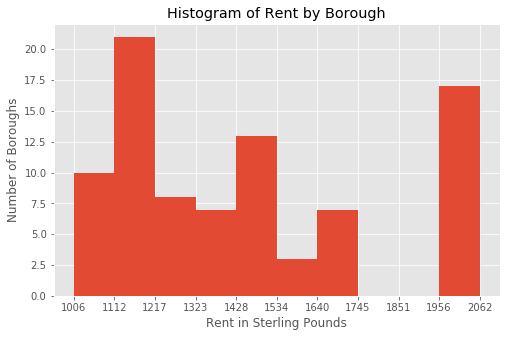

In [74]:
# Histogram of Rent by borough
count, bin_edges = np.histogram(df['Rent'])

df['Rent'].plot(kind='hist', figsize=(8, 5), xticks=bin_edges)

plt.title('Histogram of Rent by Borough')
plt.ylabel('Number of Boroughs')
plt.xlabel('Rent in Sterling Pounds')

plt.show()

The rent in this area of London is quite split in two areas: under 1745 and over 1956 pounds per month.

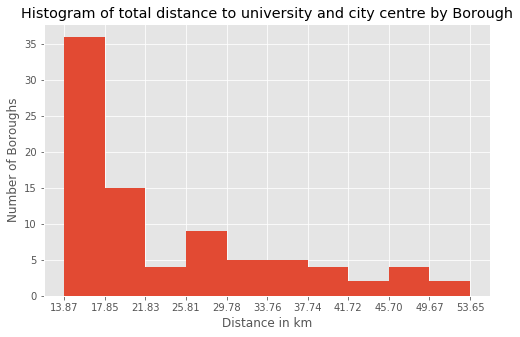

In [75]:
# Histogram of Total distance by borough
count, bin_edges = np.histogram(df['Total Distance'])

df['Total Distance'].plot(kind='hist', figsize=(8, 5), xticks=bin_edges)

plt.title('Histogram of total distance to university and city centre by Borough')
plt.ylabel('Number of Boroughs')
plt.xlabel('Distance in km')

plt.show()

The majority of the boroughs selected are within a 20 km range

### Clustering

In [76]:
df.head()

,Postcode,Latitude,Longitude,Town/Area,Region,Rent,Distance University,Distance Centre,Total Distance,Cafes,Shops
0,E1,51.5163,-0.060428,"Aldgate, Bishopsgate, Whitechapel, Shoreditch,...",Tower Hamlets,1494,20.541551,8.262813,28.804364,0.0,1.0
1,E1W,51.5118,-0.059323,Wapping,Tower Hamlets,1494,20.858766,8.356972,29.215738,0.0,0.0
2,E2,51.5301,-0.062251,"Bethnal Green, Haggerston, Shoreditch, Cambrid...",Tower Hamlets,1494,19.785227,8.340069,28.125296,0.0,0.0
3,E3,51.5282,-0.025800,"Bow, Bromley-by-Bow, Old Ford, Mile End, Three...",Tower Hamlets,1494,23.701012,12.255042,35.956053,0.0,0.0
4,E4,51.6238,-0.003245,"Chingford, Sewardstone, Highams Park",Waltham Forest,1089,25.455246,19.331905,44.787152,0.0,0.0


Unnecessary columns are dropped in order to keep only those features relevant for the analysis.

In [77]:
X = df.drop(['Postcode', 'Latitude', 'Longitude', 'Town/Area', 'Region', 'Distance Centre'], axis=1)

A quick data types check is performed to make sure all the features have the right kind of data type.

In [78]:
X.dtypes

Rent                     int64
Distance University    float64
Total Distance         float64
Cafes                  float64
Shops                  float64
dtype: object

Before clustering the data, the optimal number of clusters must be obtained. The "Elbow Criterion Method" will be used.
It is important to scale the data to avoid the distance governance of large features. The chosen method was the "Standard Scaler" 

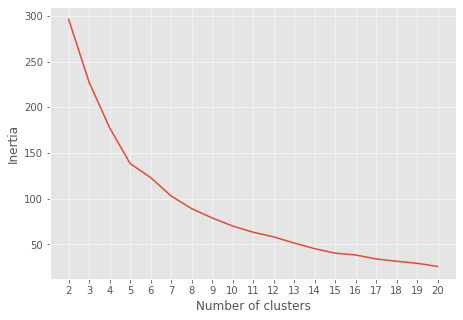

In [79]:
# Selection of optimal number of clusters:
inertia = {}
for k in range(2, 21):
    # Instantiate  KMeans and fit data
    scaler = StandardScaler()
    kmeans = KMeans(n_clusters=k)
    pipeline = make_pipeline(scaler, kmeans)
    pipeline.fit(X)
    label = kmeans.labels_
    # get inertia (Sum of distances of samples to their closest cluster center)
    inertia[k] = kmeans.inertia_

# Elbow Criterion Method: visualisation of inertia
plt.figure(figsize=(16, 5))
plt.subplot(121)
plt.plot(list(inertia.keys()), list(inertia.values()))
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.xticks(np.arange(2, 21, step=1))
plt.grid(linestyle='-', linewidth=0.5)

The optimal number of clusters was considered to be 5 or 6 according to the previous graph. A pipeline will be used to fit the scaler and the K-Means model.

In [85]:
scaler = StandardScaler()
kmeans = KMeans(n_clusters=6)
pipeline = make_pipeline(scaler, kmeans)
pipeline.fit(X)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('kmeans',
                 KMeans(algorithm='auto', copy_x=True, init='k-means++',
                        max_iter=300, n_clusters=6, n_init=10, n_jobs=None,
                        precompute_distances='auto', random_state=None,
                        tol=0.0001, verbose=0))],
         verbose=False)

In [86]:
kmeans_labels = pipeline.predict(X)
kmeans_labels

array([2, 5, 5, 5, 0, 5, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4,
       1, 1, 2, 5, 4, 2, 2, 5, 1, 1, 2, 2, 5, 5, 3, 5, 5, 1, 1, 5, 5, 2,
       2, 3, 1, 4, 1, 1, 4, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1,
       4, 4, 4, 1, 4, 1, 1, 3, 2, 2, 5, 2, 5, 3, 4, 4, 3, 2, 5, 4])

In [87]:
df['Labels'] = kmeans_labels
df_0 = df[df['Labels']==0]
df_1 = df[df['Labels']==1]
df_2 = df[df['Labels']==2]
df_3 = df[df['Labels']==3]
df_4 = df[df['Labels']==4]
df_5 = df[df['Labels']==5]

Show map with the different areas or clusters.

In [91]:
# create map of London using latitude and longitude values
map_london_f = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_0['Latitude'], df_0['Longitude'], df_0['Postcode'], df_0['Region']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london_f)  
    
for lat, lng, borough, neighborhood in zip(df_1['Latitude'], df_1['Longitude'], df_1['Postcode'], df_1['Region']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london_f)  
    
for lat, lng, borough, neighborhood in zip(df_2['Latitude'], df_2['Longitude'], df_2['Postcode'], df_2['Region']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london_f)  
    
for lat, lng, borough, neighborhood in zip(df_3['Latitude'], df_3['Longitude'], df_3['Postcode'], df_3['Region']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london_f)  
    
for lat, lng, borough, neighborhood in zip(df_4['Latitude'], df_4['Longitude'], df_4['Postcode'], df_4['Region']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='orange',
        fill=True,
        fill_color='orange',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london_f)  
    
for lat, lng, borough, neighborhood in zip(df_5['Latitude'], df_5['Longitude'], df_5['Postcode'], df_5['Region']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='purple',
        fill=True,
        fill_color='purple',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london_f)  

# add Middlesex University as a marker
folium.Marker(
    location=[latitude, longitude],
    popup='Middlesex University',
    icon=folium.Icon(color="black",icon="home", prefix='fa')
).add_to(map_london_f)

# add City Centre as a marker
folium.Marker(
    location=[latitude_pc, longitude_pc],
    popup='City Centre',
    icon=folium.Icon(color="black",icon="bank", prefix='fa')
).add_to(map_london_f)

map_london_f

In [89]:
df

,Postcode,Latitude,Longitude,Town/Area,Region,Rent,Distance University,Distance Centre,Total Distance,Cafes,Shops,Labels
0,E1,51.5163,-0.060428,"Aldgate, Bishopsgate, Whitechapel, Shoreditch,...",Tower Hamlets,1494,20.541551,8.262813,28.804364,0.0,1.0,2
1,E1W,51.5118,-0.059323,Wapping,Tower Hamlets,1494,20.858766,8.356972,29.215738,0.0,0.0,5
2,E2,51.5301,-0.062251,"Bethnal Green, Haggerston, Shoreditch, Cambrid...",Tower Hamlets,1494,19.785227,8.340069,28.125296,0.0,0.0,5
3,E3,51.5282,-0.025800,"Bow, Bromley-by-Bow, Old Ford, Mile End, Three...",Tower Hamlets,1494,23.701012,12.255042,35.956053,0.0,0.0,5
4,E4,51.6238,-0.003245,"Chingford, Sewardstone, Highams Park",Waltham Forest,1089,25.455246,19.331905,44.787152,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
81,W10,51.5202,-0.221196,"North Kensington, Queens Park",Kensington And Chelsea,2062,7.853146,9.720280,17.573426,0.0,1.0,4
82,W11,51.5128,-0.216585,"Notting Hill, Holland Park",Kensington And Chelsea,2062,8.741294,9.144339,17.885632,2.0,0.0,3
83,W12,51.5094,-0.238236,"Shepherds Bush, White City",Hammersmith And Fulham,1454,9.048913,11.546536,20.595449,1.0,1.0,2
84,W13,51.5131,-0.321423,"West Ealing, Northfields",Ealing,1216,13.340596,20.802584,34.143179,0.0,0.0,5


In [98]:
df_group = df.groupby('Labels').mean()
leyend = {0:'blue', 1:'yellow', 2:'green', 3:'red', 4:'orange', 5:'purple'}
df_group['Color'] = df_group.index.map(leyend)
df_group.drop(['Latitude', 'Longitude'], axis=1, inplace=True)
df_group


,Rent,Distance University,Distance Centre,Total Distance,Cafes,Shops,Color
Labels,,,,,,,
0,1208.000000,27.359682,17.334177,44.693859,0.307692,0.307692,blue
1,1255.842105,8.546234,7.800424,16.346658,0.052632,0.000000,yellow
2,1352.071429,12.465440,9.709652,22.175092,0.500000,1.142857,green
3,1807.500000,12.159583,7.615900,19.775483,2.500000,0.333333,red
4,1926.894737,11.639398,3.264114,14.903511,0.210526,0.157895,orange
5,1288.000000,16.754072,13.157733,29.911805,0.000000,0.000000,purple


### Results
In order to make a more conclusive analysis, more variables should be taken into consideration. For example, take-away venues may be of importance to the user, or small food stores. However, for the sake of simplicity only cafes and supermarkets have been considered in this study. Also, the distance to the closest metro station would be relevant to be added, since it is key in a city like London.

In general the results make sense and are as expected.

### Discussion
- Label 0 (blue): lowest rent, but far from university and city centre. Also a medium number of cafes and shops.
- Label 1 (yellow): second lowest rent, shortest distance to university and short distance to city centre. No supermarkets in the area and very low number of cafes. 
- Label 2 (green): affordable rents, medium distance to university and city centre. Good number of cafes and supermarkets.
- Label 3 (red): expensive area, medium distance to university but close to city centre. A great number of cafes and medium number of supermarkets.
- Label 4 (orange): very expensive area, located in city centre, medium distance to university. A medium number of cafes and medium-low number of supermarkets.
- Label 5 (purple): cheap rents, far from both university and city centre. No cafes or shops.

### Conclusion
The final choice has to be made by the person who is going to live and study in London. However, based on the analysis, __the most suitable location would be either regions in yellow (1) or in blue (green)__, depending on the preference of the user. If the main priority is being close to university, then the user should choose the yellow regions (1). If on the contrary the number of cafes and supermarkets is relevant, the user should go for the green regions (2). This conclusion is assuming the rent is a key factor to take into account due to the student condition.